In [1]:
from mxnet import image
from mxnet import nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxTarget
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
import numpy as np
from mxnet import metric
from mxnet import init
from mxnet import gpu

In [2]:
data_shape = 256
batch_size = 8
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pedestrian']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./train.rec',
        path_imgidx='./train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='../Test/test.rec',
        shuffle=False,
        mean=True)
    
    return train_iter, val_iter, class_names, num_class

In [3]:
train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)

In [4]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(8, 3, 256, 256)] label shapes: [(8, 12, 5)]


In [5]:
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

In [6]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()

In [7]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

In [8]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

In [9]:
def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

In [10]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

In [11]:
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
        
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

In [12]:
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):    
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction    
    x = body(x)
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat date
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

In [13]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, 
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation       
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

In [14]:
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

In [15]:
def focal_loss(gamma, x):
    return - (1-x)**gamma*np.log(x)

In [16]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)
cls_loss = FocalLoss()

In [17]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)
box_loss = SmoothL1Loss()

In [18]:
cls_metric = metric.Accuracy()
box_metric = metric.MAE()

In [19]:
ctx = gpu(0)
# the CUDA implementation requres each image has at least 3 lables. 
# Padd two -1 labels for each instance 
train_data.reshape(label_shape=(12, 5))
train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 
                        'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [20]:
import time
from mxnet import autograd
for epoch in range(10):
    # reset data iterators and metrics 
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(
                anchors, class_preds, y)
            # losses
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [class_preds.transpose((0,2,1))])
        box_metric.update([box_target], [box_preds * box_mask])

    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (
        epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic
    ))

Epoch  0, train accuracy 0.97, mae 0.00453, time 15.5 sec
Epoch  1, train accuracy 0.99, mae 0.00402, time 12.6 sec
Epoch  2, train accuracy 0.99, mae 0.00382, time 12.5 sec
Epoch  3, train accuracy 1.00, mae 0.00366, time 12.8 sec
Epoch  4, train accuracy 1.00, mae 0.00370, time 12.6 sec
Epoch  5, train accuracy 1.00, mae 0.00354, time 12.6 sec
Epoch  6, train accuracy 1.00, mae 0.00369, time 12.7 sec
Epoch  7, train accuracy 1.00, mae 0.00355, time 13.1 sec
Epoch  8, train accuracy 1.00, mae 0.00362, time 12.7 sec
Epoch  9, train accuracy 1.00, mae 0.00343, time 12.6 sec


In [21]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im

In [22]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=False)

In [23]:
x, im = process_image('./pred/crop_000027.png')

In [24]:
out = predict(x)

In [25]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

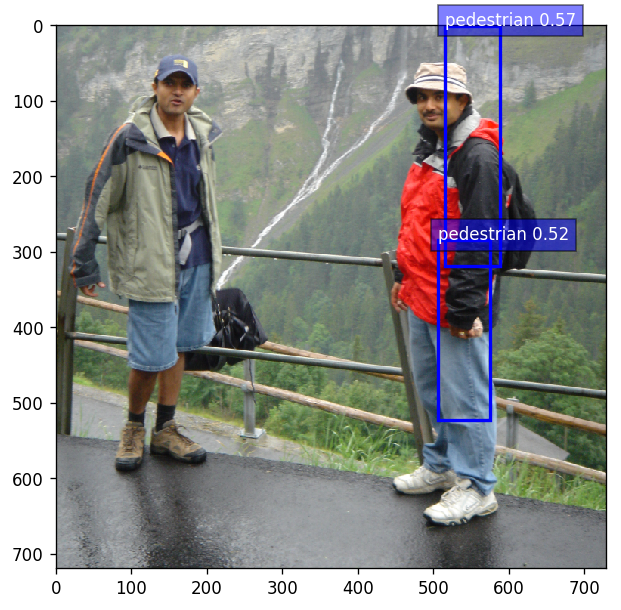

In [26]:
mpl.rcParams['figure.figsize'] = (6,6)
colors = ['blue', 'green', 'red', 'black', 'magenta']

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
                        
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.5)